# Top Hit Song Prediction
This is to test the top song prediction.

## Dependecy
Here are the depedency that I'm currently using to helping run the prediction and handling the data.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import ipywidgets as widgets
from IPython.display import display

## Cleaning Data
Before we begin with anything, the data should be cleaned first.

### Remove Missing Data
For High popularity

In [2]:
# Add csv data to songs
high_song_popularity = pd.read_csv("high_popularity_spotify_data.csv")

# Drop useless column
high_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Show the total number of null in each column.
print(high_song_popularity.isnull().sum())

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_name                  0
track_album_release_date    0
instrumentalness            0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
dtype: int64


For low popularity

In [3]:
# Add csv data to songs
low_song_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Drop useless column
low_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Drop row containing null for time_signature
low_song_popularity = low_song_popularity.dropna(subset='time_signature')

# Show the total number of null in each column.
print(low_song_popularity.isnull().sum())

time_signature              0
track_popularity            0
speechiness                 0
danceability                0
track_artist                0
duration_ms                 0
energy                      0
playlist_genre              0
playlist_subgenre           0
track_name                  0
mode                        0
track_album_release_date    0
id                          0
instrumentalness            0
valence                     0
key                         0
tempo                       0
loudness                    0
acousticness                0
liveness                    0
dtype: int64


## Audio Features
Here is the description of each audio features in the dataset.

-Energy         =   A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. The higher it is the engergetic it is.

-Tempo           =   The speed of a track, measured in beats per minute (BPM).

-Danceability    =   A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity.

-Loudness        =   The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall.

-Liveness        =   The likelihood of a track being performed live. Higher values suggest more audience presence.

-Valence         =   The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry.

-Speechiness     =   Measures the presence of spoken words.

-Instrumentalness =   The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks.

-Acousticness    =   A confidence measure of whether a track is acoustic(1) or not(0).

-Mode            =   Indicates the modality of the track.

-Key             =   The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation.

-Duration_ms     =   The length of the track in milliseconds.

In [4]:
# Avarage
high_popularity_avg = high_song_popularity['track_popularity'].mean()
low_popularity_avg = low_song_popularity['track_popularity'].mean()

# Max
max_popular_high_popularity = high_song_popularity['track_popularity'].max()
max_popular_low_popularity = low_song_popularity['track_popularity'].max()

# Min
min_popular_high_popularity = high_song_popularity['track_popularity'].min()
min_popular_low_popularity = low_song_popularity['track_popularity'].min()

# Total of number
count_max_popular_high_popularity = (high_song_popularity['track_popularity'] == 100).sum()
count_max_popular_low_popularity = (low_song_popularity['track_popularity'] == 68).sum()

count_min_popular_high_popularity = (high_song_popularity['track_popularity'] == 68).sum()
count_min_popular_low_popularity = (low_song_popularity['track_popularity'] == 11).sum()

# Show
print('popular track for high average popularity:', high_popularity_avg)
print('max popular track for high average popularity:', max_popular_high_popularity)
print('min popular track for high average popularity:', min_popular_high_popularity)
print('features for popularity')

print('popular track for low average popularity:', low_popularity_avg)
print('max popular track for low average popularity:', max_popular_low_popularity)
print('min popular track for low average popularity:', min_popular_low_popularity)
print('features for non popularity')

print('the number of high popularity for 68: ', count_min_popular_high_popularity, ' and for low popularity for 68:', count_max_popular_low_popularity)

popular track for high average popularity: 75.80604982206405
max popular track for high average popularity: 100
min popular track for high average popularity: 68
features for popularity
popular track for low average popularity: 43.47709923664122
max popular track for low average popularity: 68
min popular track for low average popularity: 11
features for non popularity
the number of high popularity for 68:  124  and for low popularity for 68: 45


## Visualization and analyze trends


### Compare The Average Popular and Non-popular Audio Features by Song Genres
This bar chart compares the average values of audio features between popular and non-popular songs across different genres. It helps artists gain insights and identify patterns in how features like energy, danceability, and tempo behave in popular versus non-popular songs within each genre.

By analyzing these differences, artists can better understand what characteristics are commonly found in successful songs in their chosen genre. This can guide them in targeting ideal feature values when producing new song.

All audio feature values in the chart are normalized to a scale between 0 and 1. This is important because features like tempo and loudness normally exist on different scales, and normalization ensures a fair visual comparison across all features.

In [5]:
# Features to include
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Combine and get min/max for normalization
combined_df = pd.concat([high_song_popularity, low_song_popularity])
feature_min = combined_df[features].min()
feature_max = combined_df[features].max()

# Normalize and retain original values for tooltip
high_norm = high_song_popularity.copy()
low_norm = low_song_popularity.copy()

for feature in features:
    high_norm[feature + '_orig'] = high_song_popularity[feature]
    low_norm[feature + '_orig'] = low_song_popularity[feature]
    high_norm[feature] = (high_song_popularity[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])
    low_norm[feature] = (low_song_popularity[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])

# Unique genres with valid data
genres = sorted(set(high_norm['playlist_genre'].unique().tolist() + low_norm['playlist_genre'].unique().tolist()))
data_by_genre = {}

for genre in genres:
    pop_filtered = high_norm[high_norm["playlist_genre"] == genre]
    non_pop_filtered = low_norm[low_norm["playlist_genre"] == genre]
    if pop_filtered.empty or non_pop_filtered.empty:
        continue

    pop_avg = pop_filtered[features].mean()
    non_pop_avg = non_pop_filtered[features].mean()
    pop_raw = pop_filtered[[f + "_orig" for f in features]].mean()
    non_pop_raw = non_pop_filtered[[f + "_orig" for f in features]].mean()

    data_by_genre[genre] = {
        "pop_norm": pop_avg,
        "non_pop_norm": non_pop_avg,
        "pop_raw": pop_raw,
        "non_pop_raw": non_pop_raw
    }

# Keep only genres with data
genres = list(data_by_genre.keys())
initial_genre = genres[0]

# Create figure with initial genre
fig = go.Figure()

# Add normalized bars with raw values in customdata
fig.add_trace(go.Bar(
    name='Popular songs',
    x=features,
    y=data_by_genre[initial_genre]['pop_norm'],
    marker_color='green',
    customdata=data_by_genre[initial_genre]['pop_raw'].values.reshape(-1, 1),
    hovertemplate='%{x}<br>Normalized: %{y:.2f}<br>Raw: %{customdata[0]:.2f}<extra></extra>'
))

fig.add_trace(go.Bar(
    name='Non-popular songs',
    x=features,
    y=data_by_genre[initial_genre]['non_pop_norm'],
    marker_color='blue',
    customdata=data_by_genre[initial_genre]['non_pop_raw'].values.reshape(-1, 1),
    hovertemplate='%{x}<br>Normalized: %{y:.2f}<br>Raw: %{customdata[0]:.2f}<extra></extra>'
))

# Dropdown buttons
dropdown_buttons = []
for genre in genres:
    dropdown_buttons.append({
        'label': genre.title(),
        'method': 'update',
        'args': [
            {
                'y': [
                    data_by_genre[genre]['pop_norm'],
                    data_by_genre[genre]['non_pop_norm']
                ],
                'customdata': [
                    data_by_genre[genre]['pop_raw'].values.reshape(-1, 1),
                    data_by_genre[genre]['non_pop_raw'].values.reshape(-1, 1)
                ]
            },
            {
                'title': f'Feature Comparison (Normalized with Raw Tooltips): Popular vs. Non-Popular {genre.title()} Songs'
            }
        ]
    })

# Layout
fig.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_buttons,
            'direction': 'down',
            'showactive': True,
            'x': 1.0,
            'y': 1.2,
            'xanchor': 'left',
            'yanchor': 'top'
        }
    ],
    title=f'Feature Comparison (Normalized with Raw Tooltips): Popular vs. Non-Popular {initial_genre.title()} Songs',
    xaxis_title='Features',
    yaxis_title='Normalized Value (0 - 1)',
    barmode='group',
    template='plotly_dark',
    height=500
)

fig.show()

#### Result
Punk is less acousticness for popularity


### Heatmap Correlation for Popular Songs Between Audio Features
This heatmap helps artists understand the relationships between different audio features. A strong positive correlation (closer to +1) means two features increase together, for example, higher energy often means higher loudness. A strong negative correlation (closer to –1) means as one feature increases, the other decreases, such as more acoustic songs often being less energetic. A correlation close to 0 means there's no meaningful relationship between the two features.

This heatmap is not about predicting popularity directly. Instead, it shows how features relate to one another across popular songs. Artists can use it to see which features influence each other, for example, if you want to raise your song’s danceability, the heatmap can show which other traits (like energy or valence) tend to rise with it.

In [6]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for both datasets
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])

# Correlation matrices
corr_popular = high_song_popularity[features].corr()

# Popular songs heatmap
fig_popular = px.imshow(
    corr_popular,
    text_auto='.2f',
    color_continuous_scale='Viridis',
    labels=dict(x="Audio Feature", y="Audio Feature", color="Correlation")
)

fig_popular.update_layout(
    title="Correlation Between Audio Features (Popular Songs)",
    width=700,
    height=700,
    template="plotly_dark"
)

# Show both
fig_popular.show()

In [7]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for fair comparison
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])

# Get all genres
genres = sorted(high_song_popularity['playlist_genre'].unique())

# Define the heatmap function
def plot_heatmap(genre):
    subset = high_song_popularity[high_song_popularity['playlist_genre'] == genre][features]
    corr = subset.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='viridis', vmin=-1, vmax=1, square=True)
    plt.title(f'Audio Feature Correlation Heatmap - {genre.capitalize()} (Popular Songs)', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Create dropdown widget
genre_selector = widgets.Dropdown(
    options=genres,
    description='Genre:',
    value=genres[0],
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Bind dropdown to function
interaction = widgets.interact(plot_heatmap, genre=genre_selector)

interactive(children=(Dropdown(description='Genre:', layout=Layout(width='300px'), options=('afrobeats', 'ambi…

# Model

## Cleaning data for model

In [ ]:
# Combined popularity
combined_popularity_df = pd.concat([high_song_popularity, low_song_popularity], ignore_index=True)

# Create "hit" column from "track_popularity" for 1 and 0 input. If populartiy is lower than 70 it's 0 and higher it's 1
combined_popularity_df['hit'] = combined_popularity_df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

# Drop non-numeric or irrelevant columns
columns_to_drop = ['track_name', 'track_artist', 'id', 'track_popularity', 'track_album_release_date',
                    'playlist_genre', 'playlist_subgenre']

# Drop useless columns for the model
combined_popularity_df = combined_popularity_df.drop(columns_to_drop)


## Train Model

Confusion Matrix:
[[636  38]
 [  8 284]]

Classification Report:
              precision    recall  f1-score   support

     Not Hit       0.99      0.94      0.97       674
         Hit       0.88      0.97      0.93       292

    accuracy                           0.95       966
   macro avg       0.93      0.96      0.95       966
weighted avg       0.96      0.95      0.95       966



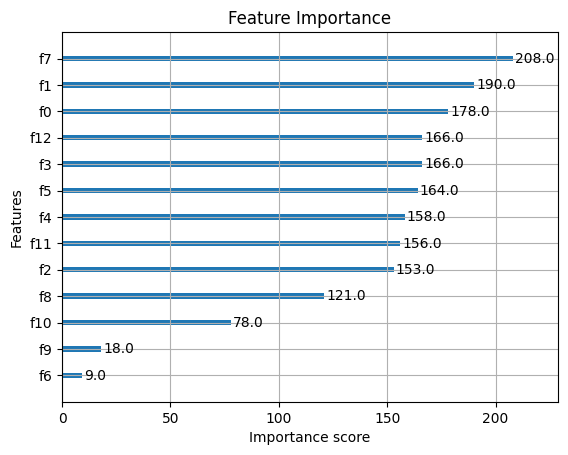

In [13]:
# Split feature and target
X = combined_popularity_df.drop('hit', axis=1) # Audio features only
y = combined_popularity_df['hit'] # This is the target which conatains the answer sheet with hit 0 means no hit and 1 means hit

# Normalize the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = XGBClassifier(eval_metric="logloss")
model.fit(X_train, y_train)

# Predict and evalute
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Hit", "Hit"]))

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()